# 5. Image Restoration and Reconstruction

## 5.3 Restoration in the Presence of Noise Only -- Spatial Filtering

### 5.3.2 Order-Statistic Filters

#### Median filter

Median filter replaces the value of a pixel by the median of the intensity levels in the neighborhood of that pixel. The value of the pixel at $(x,y)$ is included in the computation of the median.

#### Max and min filters

Using the 100th percentile results in the so-called *max filter*, this filter is useful for finding the brightest points in an image. Because pepper noise has very low values, it is reduced by this filter as a result of the max selection process in the subimage area.

The 0th percentile filter is the *min filter*. This filter is useful for finding the darkest points in an image. Also, it reduces salt noise as a result of the min operation.

#### Midpoint filter

The midpoint filter simply computes the midpoint between the maximum and minimum values in the area encompassed by the filter. Note that this filter combines order statistics and averaging. It works best for randomly distributed noise, like Gaussian or uniform noise.

### Function `spfilt`

The custom function `spfilt`, performs filtering in the spatial domain using any of the filters listed below.

|Filter name|Syntax|
|:-:|:-:|
|Arithmetic mean|**w = fspecial('average', [m n])** and **f = imfilter(g, w)**|
|Geometric mean|**f = spfilt(g, 'median', M, N)**|
|Harmonic mean|**f = spfilt(g, 'hmean', M, N)**|
|Contraharmonic mean|**f = spfilt(g, 'chmean', M, N)**|
|Median|**f = medfilt2(g, [m n], 'symmetric')** or **f = spfilt(g, 'median', M, N)**|
|Max|**f = imdilate(g, ones(m, n))** or **f = spfilt(g, 'max', M, N)**|
|Min|**f = imerode(g, ones(m, n))** or **f = spfilt(g, 'min', M, N)**|
|Midpoint|**f = spfilt(g, 'midpoint', M, N)**|
|Alpha-trimmed mean|**f = spfilt(g, 'atrimmed', M, N, D)**|

## Example 5.3: Illustration of order-statistic filters.

#### Median filter

Figure 5.10(a) shows the circuit board image corrupted by salt-and-pepper noise with probabilities $P_a=P_b=0.1$.

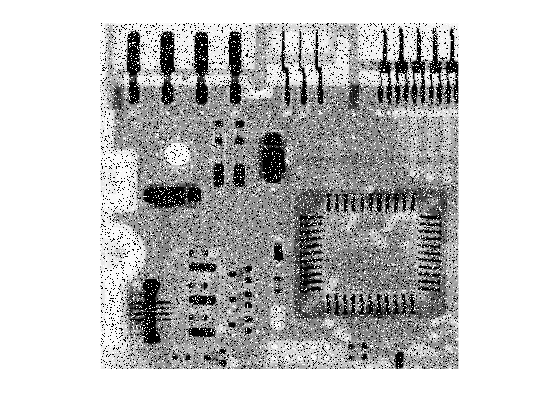

In [1]:
f = imread('Fig0510(a).tif');
imshow(f);

Figure 5.10(b) shows the result of median filtering with a filter of size $3\times 3$. The improvement over Figure 5.10(a) is significant, but several noise points still are visible.

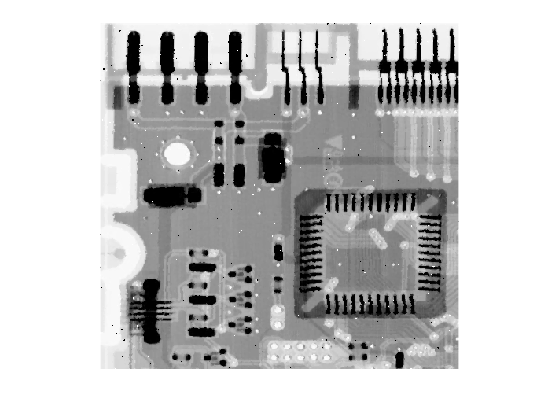

In [2]:
g1 = spfilt(f, 'median', 3, 3);
figure, imshow(g1);

A second pass on the image in Fig. 5.10(b) with the median filter removed most of these points, leaving only few, barely visible noise points.

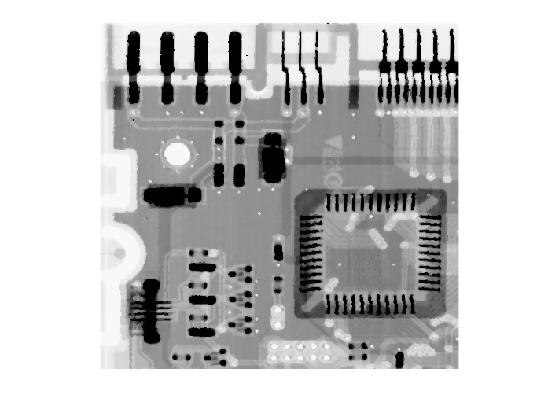

In [4]:
g2 = spfilt(g1, 'median', 3, 3);
figure, imshow(g2);

Noise points were removed with a third pass of the filter. 

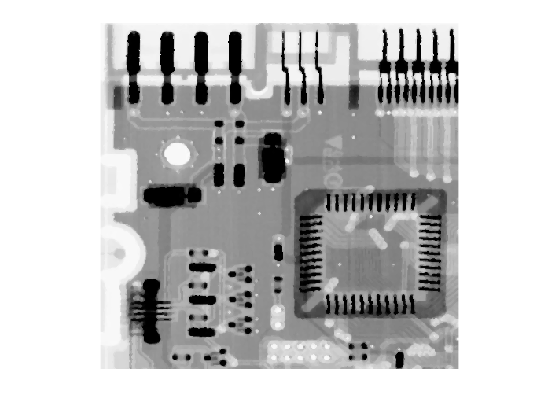

In [5]:
g3 = spfilt(g2, 'median', 3, 3);
figure, imshow(g3);

These results are good examples of the power of median filtering in handling impulse-like aditive noise. Keep in mind that repeated passes of a median filter will blur the image, so it is desirable to keep the number of passes as low as possible.

#### Max and min filters

The next image shows the result of applying the max filter to the pepper noise image of Fig. 5.8(a). The filter did a reasonable job of removing the pepper noise, but we note that it also removed (set to a light intensity level) some dark pixels from the borders of the dark objects.

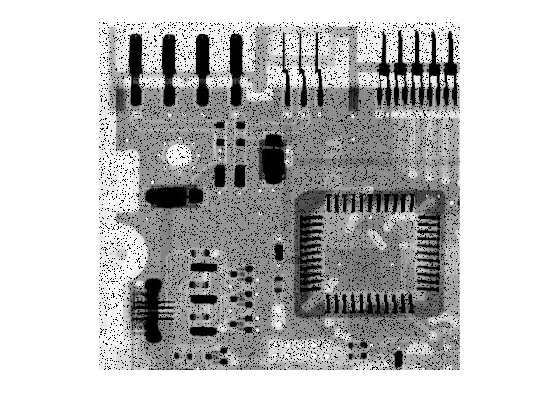

In [6]:
f = imread('Fig0508(a).tif');
imshow(f);

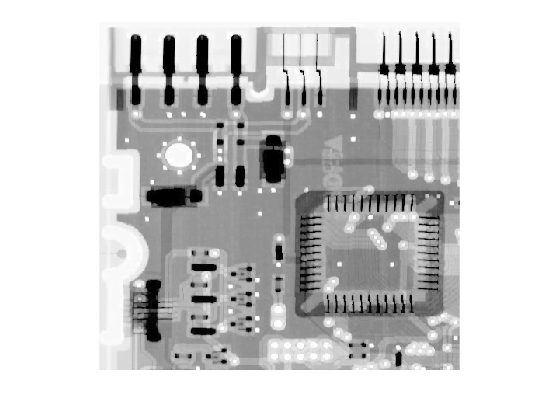

In [7]:
g = spfilt(f, 'max', 3, 3);
figure, imshow(g);

The next image shows the result of applying the min filter to the image in Fig. 5.8(b). In this case, the min filter did a better job than the max filter on noise removal, but it removed some white points around the border of light objects. These made the light objects smaller and some of the dark objects larger (like the connector fingers in the top of the image) because white points around these objects were set to a dark level.

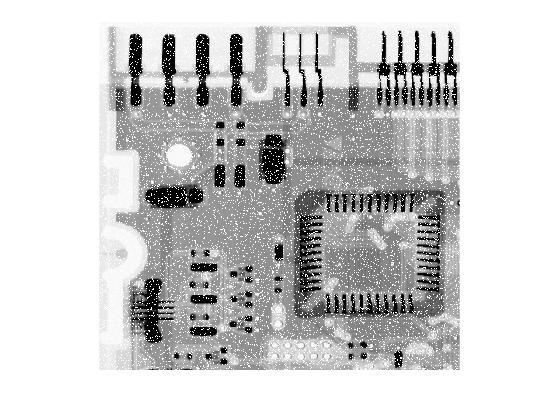

In [8]:
f = imread('Fig0508(b).tif');
imshow(f);

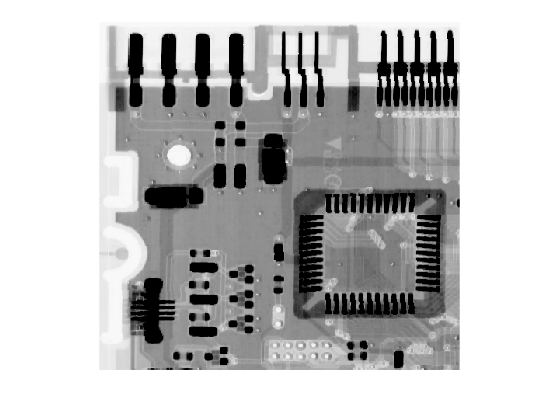

In [9]:
g = spfilt(f, 'min', 3, 3);
figure, imshow(g);

## 5.7-8 Direct Inverse Filtering and Minimum Mean Square Error (Wiener) Filtering

### Function `deconvwnr`

Wiener filtering is implemented by the function `deconvwnr`, which has three possible syntax forms. In all three forms, $g$ denotes the degraded image and $frest$ is the restored image.

The first syntax form, 

**frest = deconvwnr(g, PSF)**

assumes that the noise-to-signal ratio is zero. Thus, this form of the Wiener filter is the inverse filter.

The syntax

**frest = deconvwnr(g, PSF, NSPR)**

assumes that the noise-to-signal power ratio is known, either as a constant or as an array. This is the syntax used to implement the parametric Wiener filter, in which case `NSPR` would be a scalar input.

Finally, the syntax

**frest = deconvwnr(g, PSF, NACORR, FACORR)**

assumes that autocorrection functions, `NACORR` and `FACORR`, of the noise and undergraded image are known.

### Example 4.8: Using function `deconvwnr` to restore a blurred noisy image.

The original image is a checkboard generated by the following command:

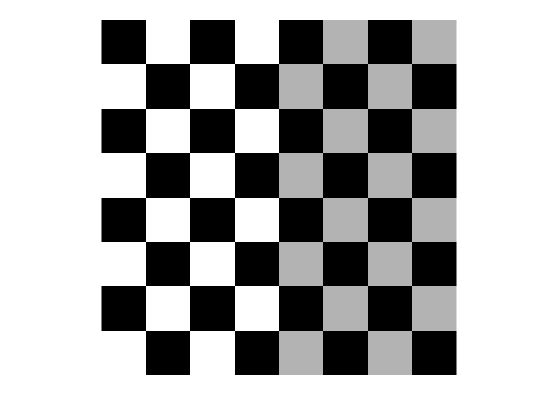

In [102]:
f = checkerboard(8);
imshow(pixeldup(f, 8));

***Note:*** in this example, all displayed images were processed with `pixeldup` to zoom their size to $512\times 512$ pixels.

The point spread function, `PSF`, is generated by function `fspecial`.

And the degraded image below was generated using the following commands:

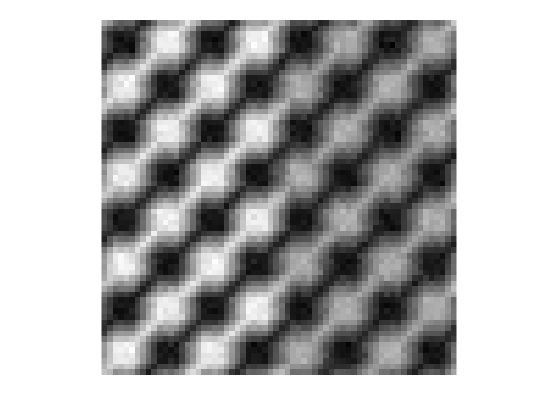

In [103]:
PSF = fspecial('motion', 7, 45);
gb = imfilter(f, PSF, 'circular');

noise = imnoise2('Gaussian', size(f, 1), size(f, 2), 0, sqrt(0.001));

g = gb + noise;
figure, imshow(pixeldup(g, 8), []);

`frest1` is the result of direct inverse filtering and, as expected, the result is dominated by the effects of noise.

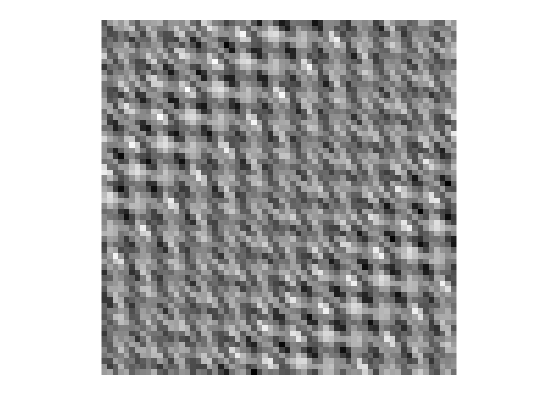

In [104]:
frest1 = deconvwnr(g, PSF);
figure, imshow(pixeldup(frest1, 8), []);

Next, we use a constant ratio Wiener filtering:

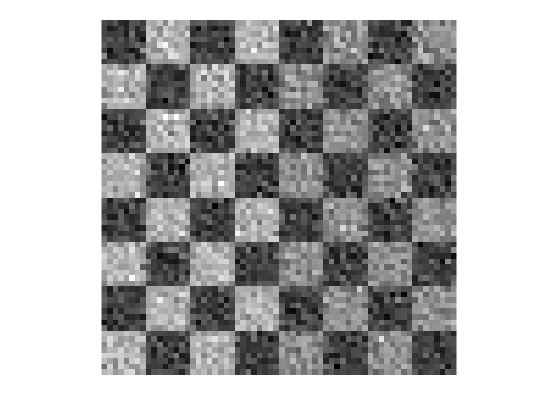

In [105]:
Sn = abs(fft2(noise)) .^ 2;
nA = sum(Sn(:)) / numel(noise);
Sf = abs(fft2(f)) .^ 2;
fA = sum(Sf(:)) / numel(f);
R = nA / fA;

frest2 = deconvwnr(g, PSF, R);
imshow(pixeldup(frest2, 8), []);

Finally, we use the autocorrection functions in the restoration (note the use of `fftshift` for centering):

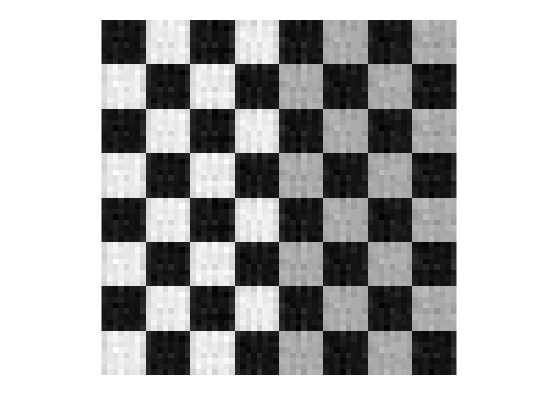

In [106]:
NCORR = fftshift(real(ifft2(Sn)));
ICORR = fftshift(real(ifft2(Sf)));
frest3 = deconvwnr(g, PSF, NCORR, ICORR);
imshow(pixeldup(frest3, 8), []);

## 5.9 Constrained Least Squares (Regularized) Filtering

### Function `deconvreg`

Constrained least squares filtering is implemented in the toolbox by function `deconvreg`, which has the syntax:

**frest = deconvreg(g, PSF, NOISEPOWER, RANGE)**

where $g$ is the corrupted image, `frest` is the restored image, `NOISEPOWER` is proportional to $||\eta||^2$, and `RANGE` is the range of values where the algorithm is limited to look for a solution for $\gamma$. The default range is $[10^{-9},10^9]$ (`[1e-9, 1e9]` in MATLAB notation).

### Example 4.9: Using function `deconvreg` to restore a blurred, noisy image.

We now restore the image in the last picture of the previous experiment. The image is of size $64\times 64$ and we know that the noise has a variance of 0.001 and zero mean. So, our initial estimate of `NOISEPOWER` is $(64)^2(0.001+0)\approx 4$

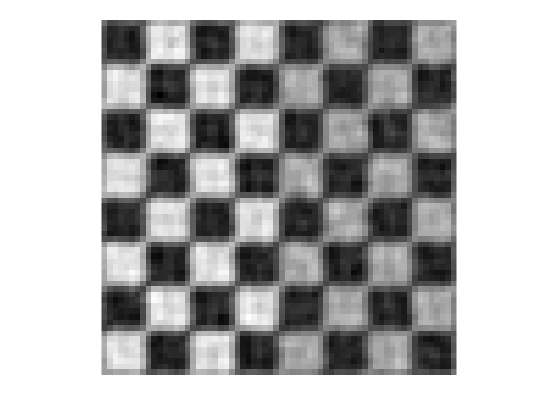

In [3]:
f = checkerboard(8);

PSF = fspecial('motion', 7, 45);
gb = imfilter(f, PSF, 'circular');

noise = imnoise2('gaussian', size(f, 1), size(f, 2), 0, sqrt(0.001));

g = gb + noise;

frest1 = deconvreg(g, PSF, 4);
imshow(pixeldup(frest1, 8), []);

The image was improved somewhat from the original, but obviously this is not a particularly good value of `NOISEPOWER`. After some experimenting with this parameter and parameter `RANGE`, we arrived at the following result, which was obtained using the commands:

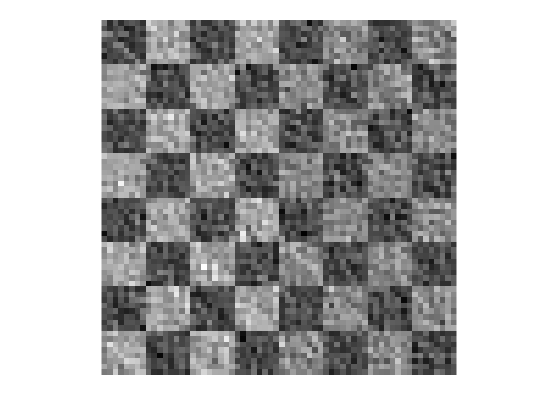

In [4]:
frest2 = deconvreg(g, PSF, 0.4, [1e-7 1e7]);
imshow(pixeldup(frest2, 8), []);